In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from torchvision.utils import save_image
import imageio

import copy

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# Loading Images

In [90]:
# desired size of the output image
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(r"data\style-images\ben_giles.jpg") # Specify Destination of style image
content_img = image_loader(r"data\content-images\figures.jpg") # Specify Destination of content image


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

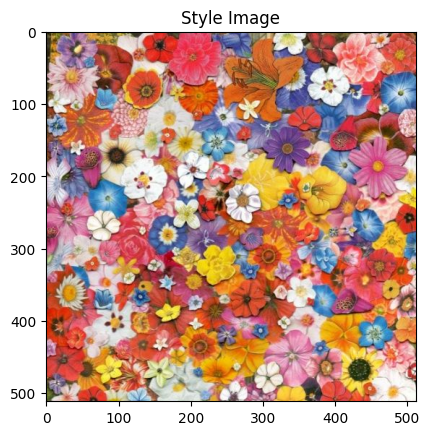

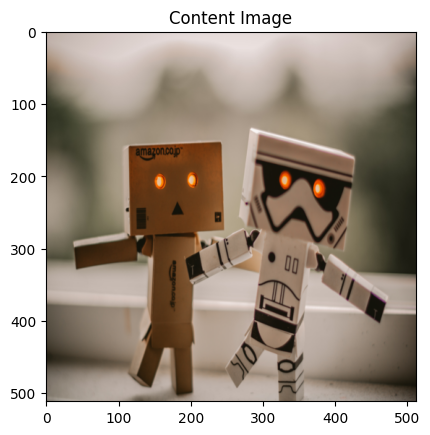

In [91]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None, subplot_index=None):
    if subplot_index is not None:
        plt.subplot(subplot_index)
    
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Defining content and style loss

In [92]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [93]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [94]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [95]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

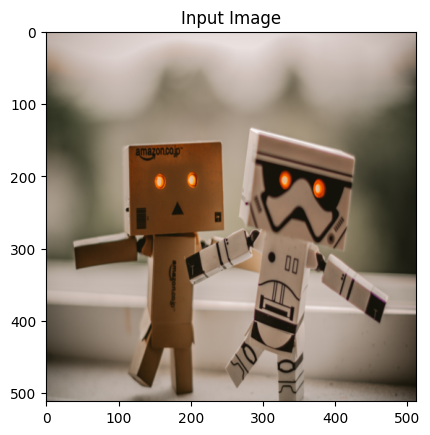

In [96]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# Style Transfer Algo Imlementation

In [97]:
style_images = [] #List to save output of every Image
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def display_iteration_image(input_img, iteration):
    with torch.no_grad():
        input_img.clamp_(0, 1)
    imshow(input_img, "Iteration {}".format(iteration))

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        
        display_iteration_image(input_img, run[0])
        style_images.append(input_img.clone())
        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# Running style transfer

Building the style transfer model..
Optimizing..


c:\Users\nisha\anaconda3\envs\myenv\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


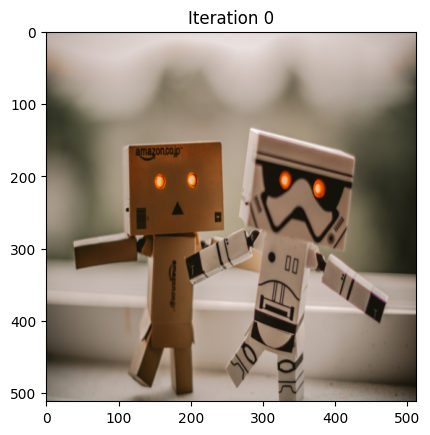

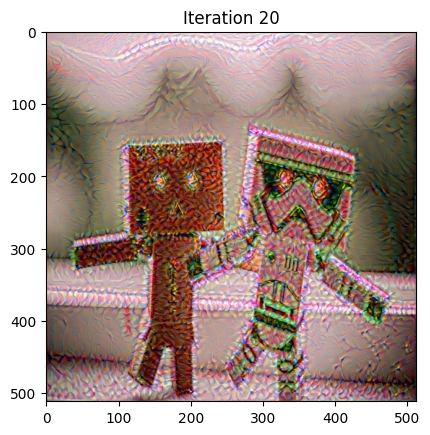

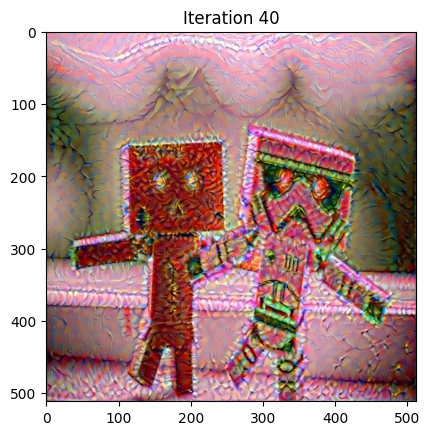

run [50]:
Style Loss : 187.618011 Content Loss: 32.630402



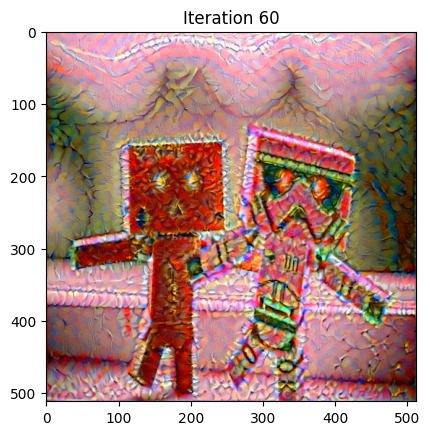

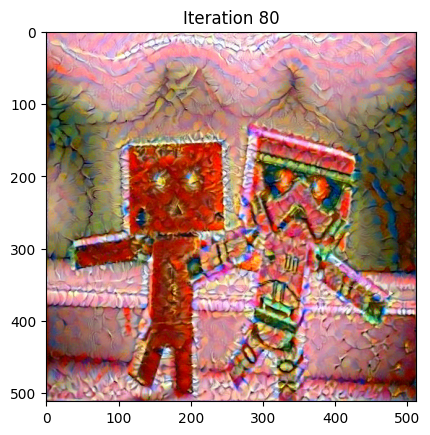

run [100]:
Style Loss : 45.733688 Content Loss: 32.277168



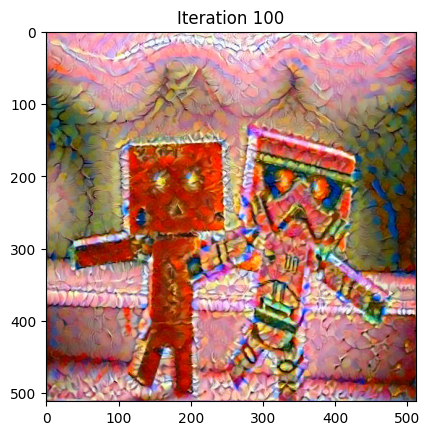

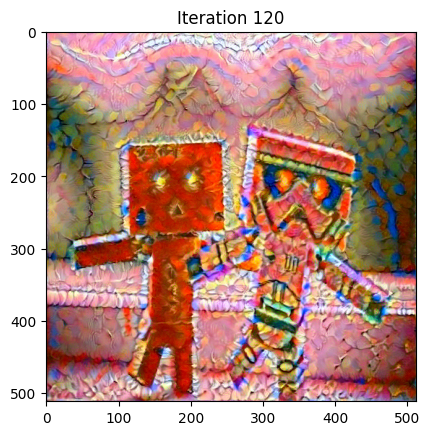

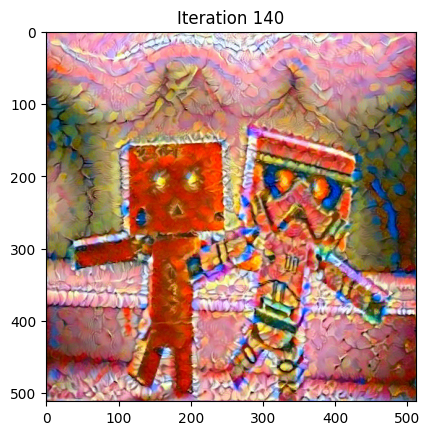

run [150]:
Style Loss : 16.867386 Content Loss: 31.238337



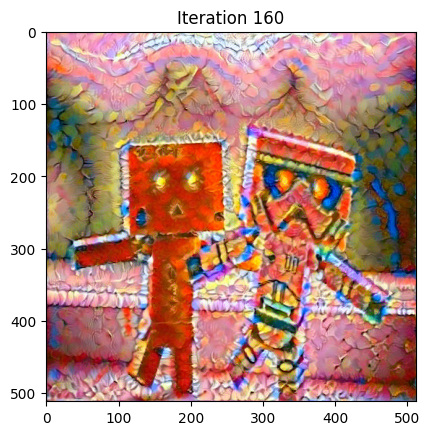

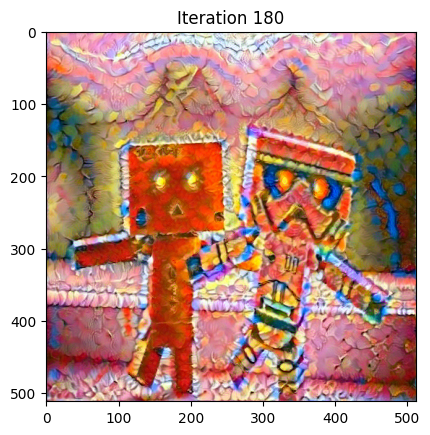

run [200]:
Style Loss : 7.211315 Content Loss: 29.631813



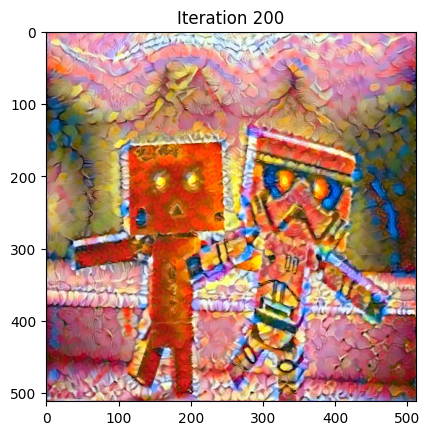

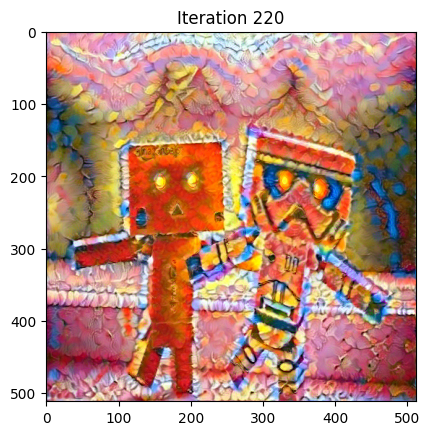

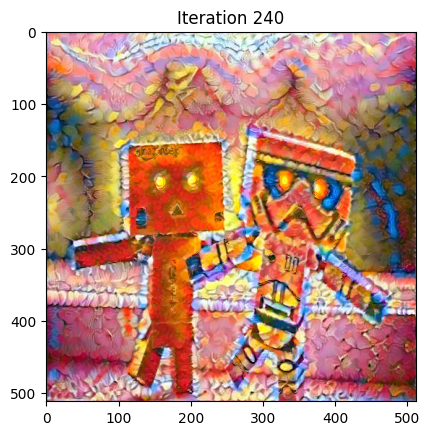

run [250]:
Style Loss : 3.302265 Content Loss: 28.343485



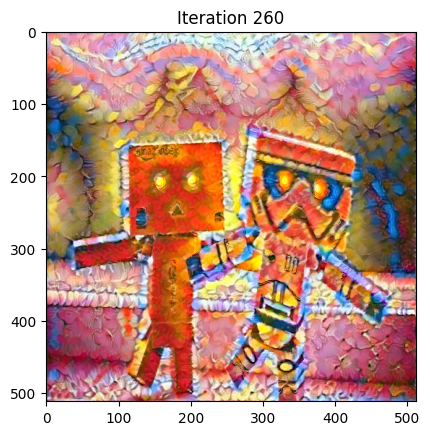

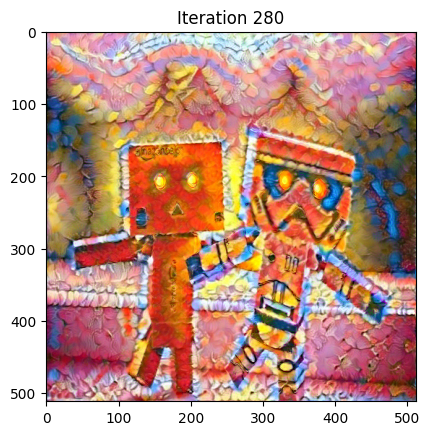

run [300]:
Style Loss : 2.066890 Content Loss: 27.099293



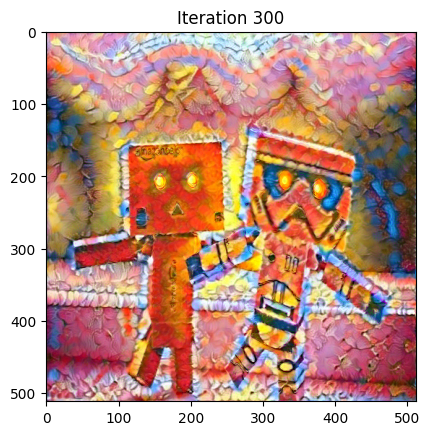

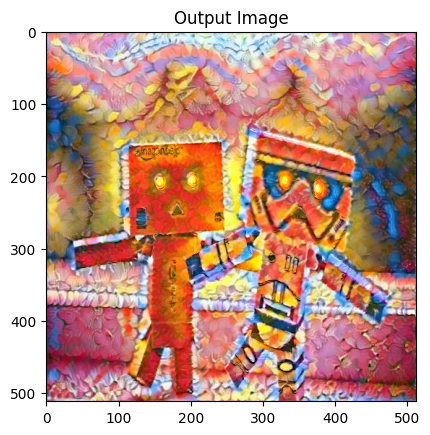

In [98]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

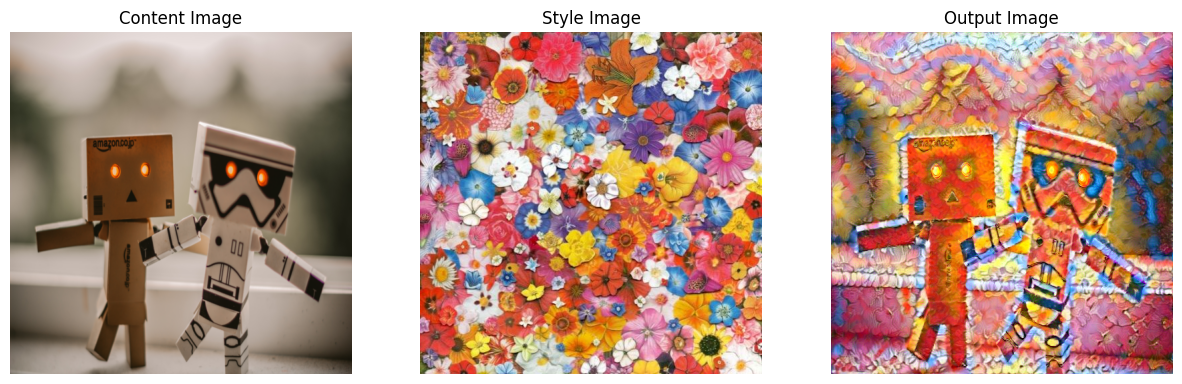

In [104]:
plt.figure(figsize=(15, 5))

# Display Content Image
plt.subplot(1, 3, 1)
image = content_img.cpu().clone().squeeze(0)
image = unloader(image)
plt.imshow(image)
plt.title('Content Image')
plt.axis('off')

# Display Style Image
plt.subplot(1, 3, 2)
image = style_img.cpu().clone().squeeze(0)
image = unloader(image)
plt.imshow(image)
plt.title('Style Image')
plt.axis('off')

# Display Output Image
plt.subplot(1, 3, 3)
image = output.cpu().clone().squeeze(0)
image = unloader(image)
plt.imshow(image)
plt.title('Output Image')
plt.axis('off')
plt.savefig('output.png')
plt.show()


In [100]:
imageio.mimsave('style_transfer_iterations.gif', [unloader(img.cpu().squeeze(0)) for img in style_images]) # Saving iteration outputs

# Recommendations to Improve Style Transfer

1. Choose a More Complex Model: 
Consider using a deeper or more complex neural network for style transfer. While VGG19 is a popular choice, experimenting with other architectures like ResNet or DenseNet might yield different and possibly better results.

2. Adjust Hyperparameters: 
Fine-tune hyperparameters such as the style and content weights, as well as the total variation weight. Different combinations can have a significant impact on the final stylized image.

3. Use Multiple Style Images: 
Extend your model to handle multiple style images. This can lead to more creative and diverse stylizations.

4. Incorporate Semantic Masks: 
Include semantic masks to guide the style transfer process. This can help control the stylization in specific regions of the content image

5. Implement Instance Normalization: 
Replace or combine batch normalization with instance normalization. Instance normalization has been shown to be effective in improving style transfer quality.

6. Explore Different Loss Functions: 
Experiment with alternative loss functions to improve the convergence and quality of stylized images.

7. Optimize for Speed: 
If real-time applications are a priority, explore optimization techniques such as network pruning or quantization to make the model more efficient.

8. Transfer Learning: 
Fine-tune your model on a dataset with a variety of styles to make it more versatile.

9. Data Augmentation: 
Augment your training dataset with various transformations to improve the model's ability to handle different styles

10. Regularization Techniques: 
Incorporate regularization techniques, such as total variation regularization, to reduce artifacts in the generated images.

Style transfer using Generative Adversarial Networks (GANs) or other methods depends on your specific requirements and the characteristics of the data you are working with. Both GAN-based and non-GAN-based approaches have their strengths and weaknesses. Here's a brief overview of each:

- Neural Style Transfer (Non-GAN-Based):

Pros:
Simplicity: Neural style transfer methods are relatively easy to understand and implement.
Fast Inference: Training and inference times are usually faster compared to GANs.
Cons:
Limited Flexibility: Non-GAN-based methods might struggle to capture complex styles or generate high-resolution images.

- GAN-Based:

Pros:
High-Quality Results: GANs, particularly StyleGAN and its variants, are known for generating high-quality, realistic images.
Flexibility: GANs can be adapted to various tasks, including style transfer.
Cons:
Complexity: Implementing and training GANs can be more challenging than non-GAN-based methods.
Longer Training Times: GANs often require longer training times and more computational resources.
Choosing an Approach:

Data Availability: If you have a large dataset with diverse styles, a GAN-based approach like StyleGAN might be beneficial.
Task Complexity: For simpler tasks or when computational resources are limited, non-GAN-based methods may be more suitable.
Generality vs. Specificity: GANs can learn more generalized representations, while non-GAN-based methods might be better at capturing specific styles.